<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/4.%20EDA/EAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.feature_selection import mutual_info_classif

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 240)

In [4]:
# !wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/clean_data.csv' -O clean_data.csv

# Load the downloaded CSV files into pandas DataFrames
data = pd.read_csv('clean_data.csv')

In [5]:
X = data.drop('Diagnosis', axis=1)  # Features
y = data['Diagnosis']               # Target variable

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Distribution of Diagnosis

<Axes: xlabel='Diagnosis', ylabel='count'>

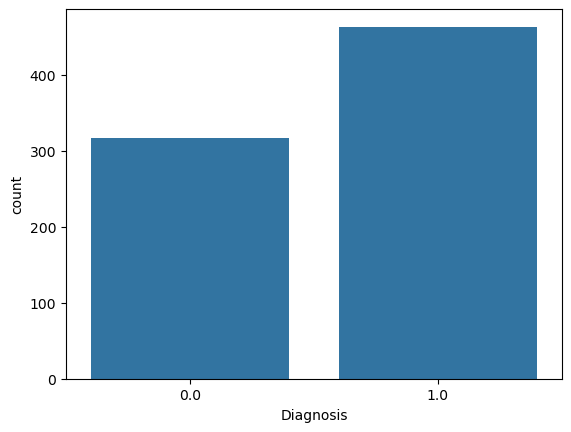

In [6]:
sns.countplot(x='Diagnosis', data=data)

## Correlation Analysis
This analysis and plot provides insight into the interdependencies among features in the dataset. Features with very high average correlations might be candidates for further examination to see if any can be removed to reduce multicollinearity, especially for the use of linear models or other algorithms that assume feature independence.

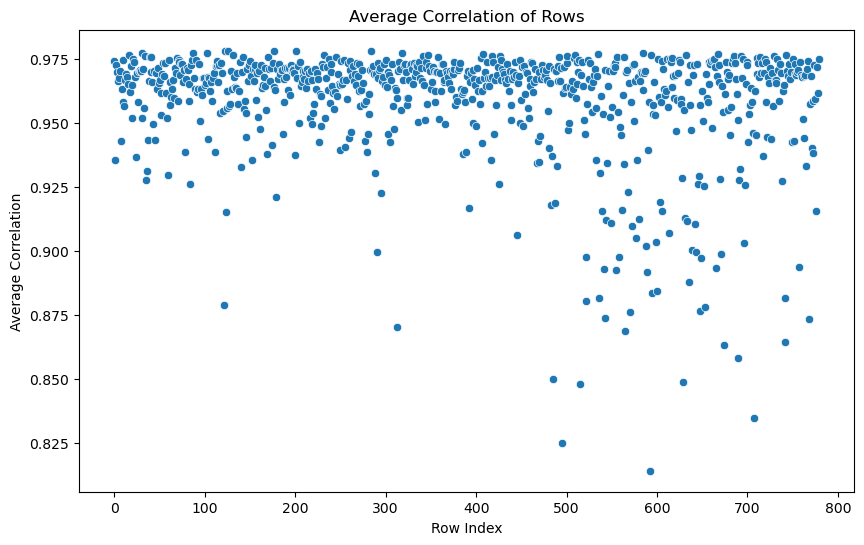

In [7]:
data_transposed = data.transpose()
correlation_rows = data_transposed.corr()
mean_correlation_rows = correlation_rows.mean(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=mean_correlation_rows.index, y=mean_correlation_rows, data=data)
plt.xlabel('Row Index')
plt.ylabel('Average Correlation')
plt.title('Average Correlation of Rows')
plt.show()

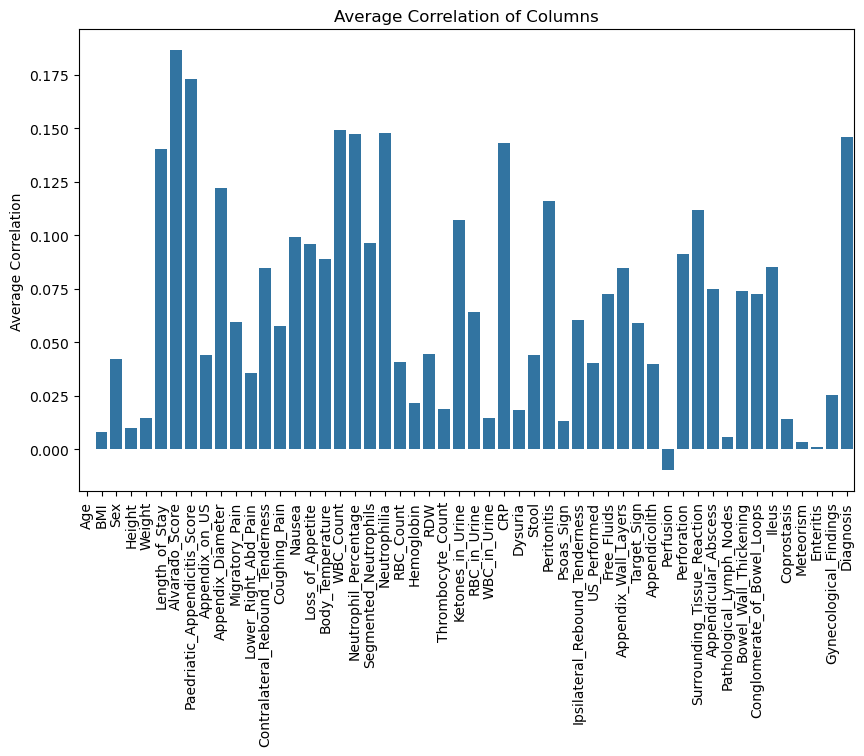

In [8]:
correlation_columns = data.corr()
mean_correlation_columns = correlation_columns.mean(axis=1)
mean_correlation_columns = mean_correlation_columns.reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='index', y=0, data=mean_correlation_columns)
plt.xlabel('')
plt.ylabel('Average Correlation')
plt.title('Average Correlation of Columns')
plt.xticks(rotation=90)
plt.show()

The plot reveals that while most features have relatively low average correlations with each other, a few features stand out with higher average correlations, peaking at certain column indices. This may indicate redundancy among some of the features, which could be further investigated for feature selection, especially if using modeling techniques that assume feature independence.

## Information Gain

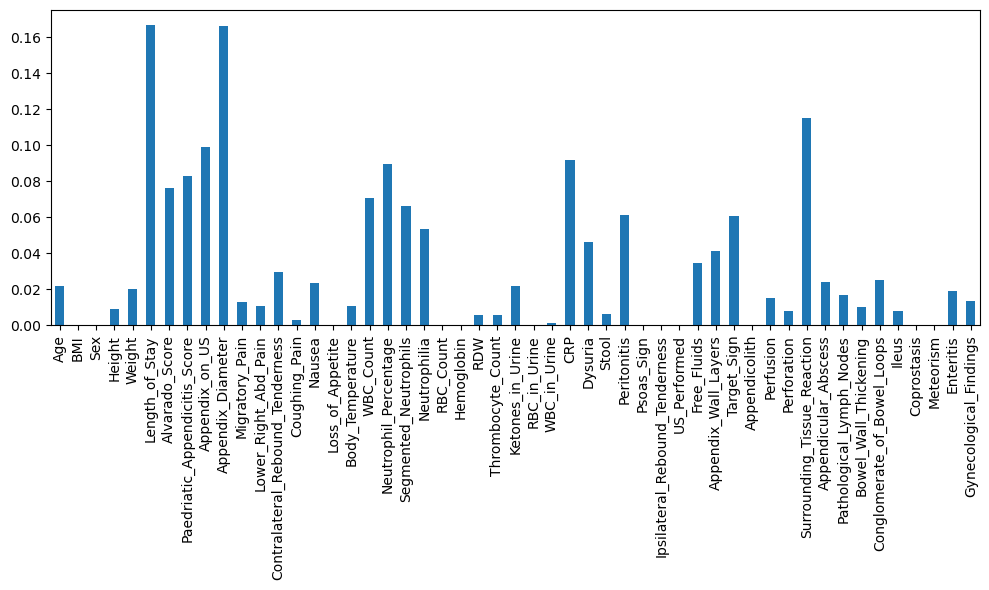

In [25]:
importances = mutual_info_classif(X,y)
feat_importances = pd.Series(importances, X.columns[0:len(X.columns)])

plt.figure(figsize=(10, 6))
feat_importances.plot(kind="bar")
plt.tight_layout()
plt.show()

In [31]:
feat_importances_sorted = feat_importances.sort_values(ascending=False)
feat_importances_sorted.head(10)

Length_of_Stay                   0.166890
Appendix_Diameter                0.166619
Surrounding_Tissue_Reaction      0.115457
Appendix_on_US                   0.099265
CRP                              0.092049
Neutrophil_Percentage            0.089686
Paedriatic_Appendicitis_Score    0.083108
Alvarado_Score                   0.076450
WBC_Count                        0.070573
Segmented_Neutrophils            0.066100
dtype: float64

## PRINCIPAL COMPONENT ANALYSIS
PCA is a powerful technique for extracting patterns from complex datasets by creating new uncorrelated variables (principal components) that maximize variance. This dimensionality reduction method transforms the data into a smaller number of dimensions, which can reveal the underlying structure of the features and help visualize high-dimensional data in a more tractable form. By analyzing the principal components, we can identify the most significant relationships within the data, reduce the impact of noise and collinearity, and improve the interpretability and efficiency of subsequent models.

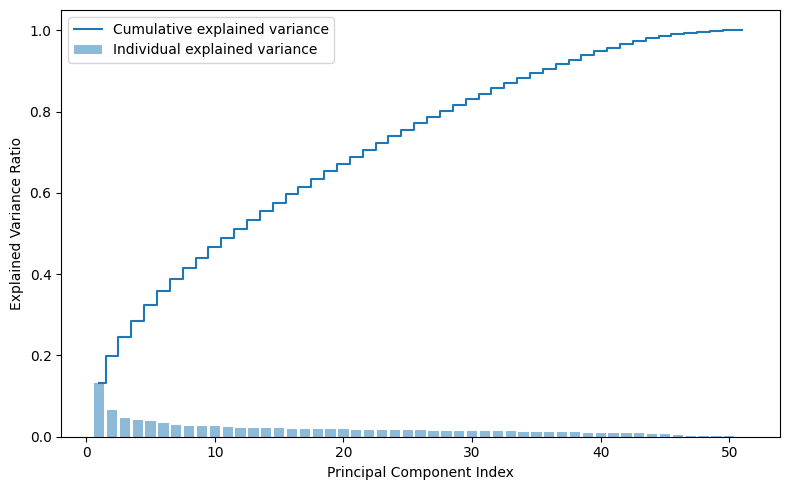

In [10]:
# Create a pipeline to standardize data and then apply PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

X_pca = pipeline.fit_transform(X)

# The explained_variance_ratio_ gives us the variance contributed by each of the components
# We can use it to plot the cumulative variance explained by the components
explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1),
        explained_variance, alpha=0.5,
        align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1),
         np.cumsum(explained_variance),
         where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [11]:
# Loadings of PC's
loadings = pipeline.named_steps['pca'].components_
n_components = 2

# df with loadings
loadings_df = pd.DataFrame(loadings[:n_components], columns=X.columns)
loadings_df = loadings_df.T

loadings_df.head()

,0,1
Age,-0.184464,0.388357
BMI,-0.143184,0.333618
Sex,0.065829,-0.027741
Height,-0.174856,0.406546
Weight,-0.177468,0.429160


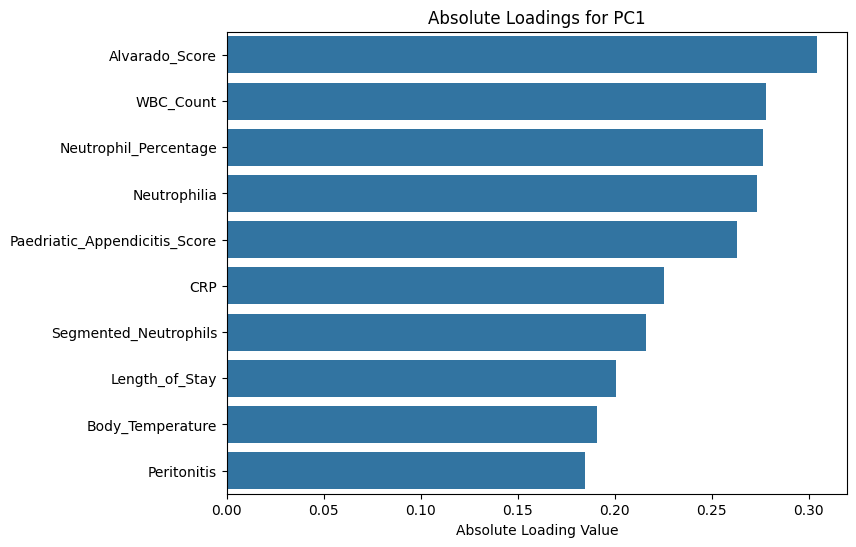

In [12]:
loadings_pc1 = loadings_df.iloc[:, 0].abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=loadings_pc1.values, y=loadings_pc1.index)

plt.title('Absolute Loadings for PC1')
plt.xlabel('Absolute Loading Value')
plt.ylabel('')
plt.show()

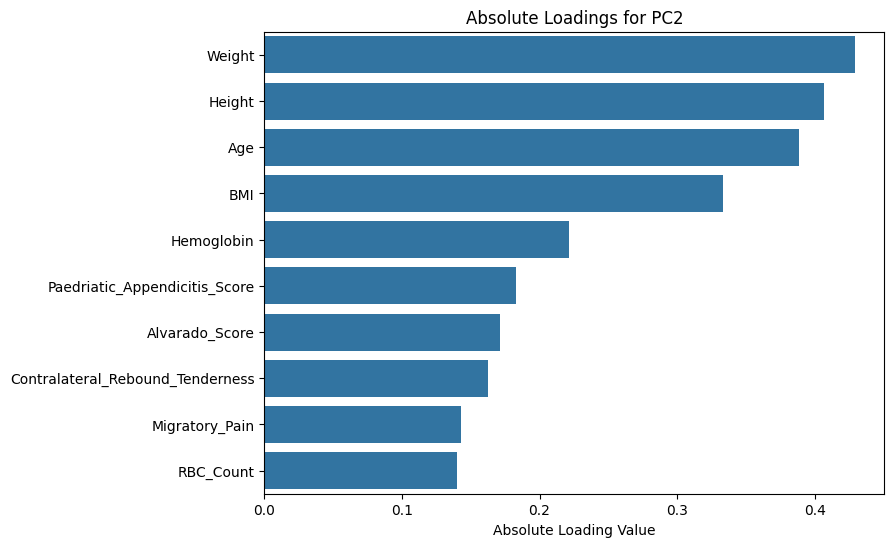

In [13]:
loadings_pc2 = loadings_df.iloc[:, -1].abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=loadings_pc2.values, y=loadings_pc2.index)

plt.title('Absolute Loadings for PC2')
plt.xlabel('Absolute Loading Value')
plt.ylabel('')
plt.show()

This list shows the loadings for the first 10 principal components derived from the PCA. Each value represents the weight of the corresponding feature in this principal component. The principal components themselves are a linear combination of all the original features, weighted by these loading values. In general, the larger the absolute value of the loading, the more the feature contributes to the component. In the context of the data, this first principal component seems to be influenced the most by features like the Alvarado Score, WBC Count, Neutrophil Percentage, and Paediatric Appendicitis Score, among others, suggesting these features play a significant role in the variance this component represents.

**RANDOM FOREST**

Random Forest is an ensemble learning technique known for its high accuracy and robustness. It operates by constructing multiple decision trees during the training process and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. In our EDA, we employ Random Forest not only as a predictive model but also as a means to assess the importance of different features. By examining feature importances, we can discern which variables have the most significant impact on the predictive power of the model, which may guide us in feature selection and model simplification.

In [14]:
# Create a pipeline with a RandomForestClassifier with a specified number of estimators and a fixed random state for reproducibility that first scales the features then trains a RandomForest model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Random Forest classifier
])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9230769230769231


**FEATURE IMPORTANCE**

Feature importance scores provide insight into the predictive power of each feature in the model. Higher scores indicate a greater influence on the model's decision-making process. These scores are useful for selecting features, understanding data, and improving model interpretability. The numeric importance values represent the weight of each feature, with higher values indicating stronger predictive power.

In [15]:
# Calculate feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

                             Feature  Importance
9                  Appendix_Diameter    0.172122
8                     Appendix_on_US    0.119076
5                     Length_of_Stay    0.107760
17                         WBC_Count    0.051018
28                               CRP    0.049358
41       Surrounding_Tissue_Reaction    0.041543
18             Neutrophil_Percentage    0.040044
6                     Alvarado_Score    0.032282
7      Paedriatic_Appendicitis_Score    0.028493
19             Segmented_Neutrophils    0.026325
24                 Thrombocyte_Count    0.023749
0                                Age    0.022603
21                         RBC_Count    0.022583
4                             Weight    0.022383
16                  Body_Temperature    0.022021
3                             Height    0.021393
31                       Peritonitis    0.020720
22                        Hemoglobin    0.020016
1                                BMI    0.017792
23                  

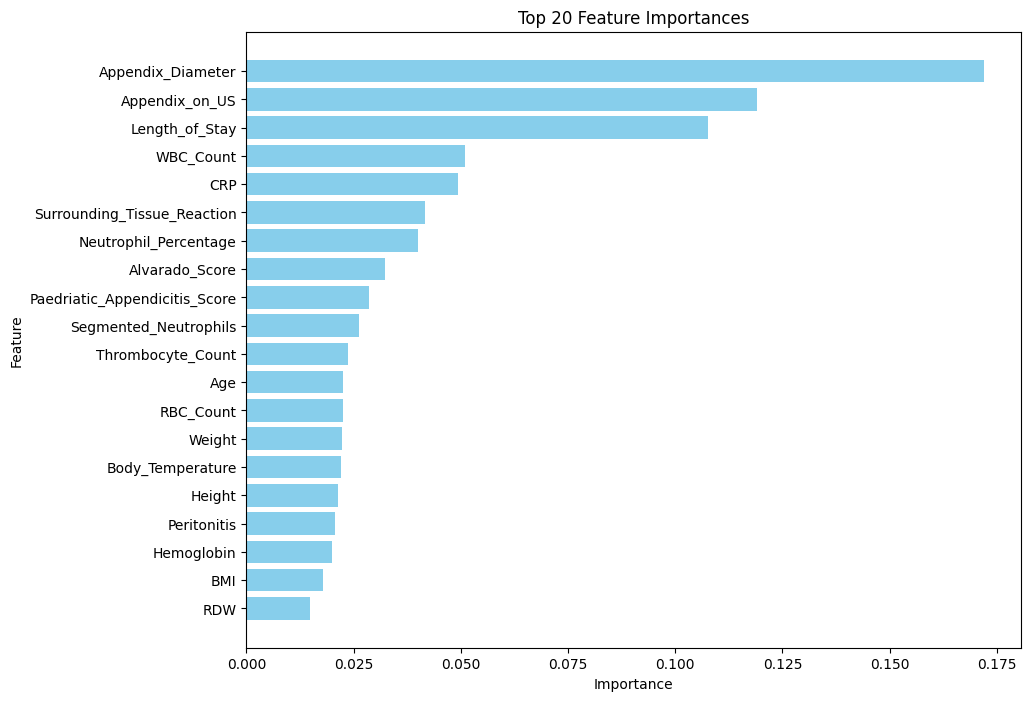

In [16]:
# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importances_df['Feature'][:20], importances_df['Importance'][:20], color='skyblue')  # top 20 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # highest importance at the top
plt.show()

The bar plot displays the top 20 features ranked by their importance scores as determined by the model. Notably, 'Appendix_Diameter' and 'Appendix_on_US' emerge as the most impactful features.

**Feature Selection with LASSO or Elastic Net Introduction**

"LASSO (Least Absolute Shrinkage and Selection Operator) and Elastic Net are regularization techniques that not only prevent overfitting by penalizing complex models but also perform feature selection. LASSO does this by penalizing the absolute size of the regression coefficients, driving some to zero, effectively selecting a simpler model that does not include those features.

In [17]:
# Set up the pipeline
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(cv=5, random_state=42))
])

# Fit the pipeline and print selected features by Lasso
pipeline_lasso.fit(X, y)
selected_features_lasso = X.columns[(pipeline_lasso.named_steps['lasso_cv'].coef_ != 0)]
print('Selected features by LASSO:', selected_features_lasso)

Selected features by LASSO: Index(['Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'WBC_Count', 'Segmented_Neutrophils', 'Thrombocyte_Count',
       'CRP', 'Stool', 'Peritonitis', 'US_Performed', 'Target_Sign', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Bowel_Wall_Thickening', 'Ileus', 'Enteritis', 'Gynecological_Findings'],
      dtype='object')


Elastic Net combines LASSO's L1 penalty with Ridge Regression's L2 penalty, balancing feature selection with coefficient shrinkage. Incorporating cross-validation, we can optimize the regularization strength to find the most predictive features while maintaining model simplicity.

In [18]:
# Set up the pipeline for ElasticNet with cross-validation
pipeline_elasticnet = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet_cv', ElasticNetCV(cv=5, random_state=42))
])

# Fit the pipeline and print selected features by ElasticNet
pipeline_elasticnet.fit(X, y)
selected_features_elasticnet = X.columns[(pipeline_elasticnet.named_steps['elasticnet_cv'].coef_ != 0)]
print('Selected features by ElasticNet:', selected_features_elasticnet)

Selected features by ElasticNet: Index(['Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils',
       'Thrombocyte_Count', 'CRP', 'Stool', 'Peritonitis', 'US_Performed', 'Target_Sign', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Bowel_Wall_Thickening', 'Ileus', 'Enteritis', 'Gynecological_Findings'],
      dtype='object')


**Correlation with Target Variable**

To understand how the features correlate with the target variable, we can calculate the correlation coefficient for each feature with the target. This step can highlight which features have the strongest linear relationship with the target variable, guiding feature selection and offering insights into the structure of the model.

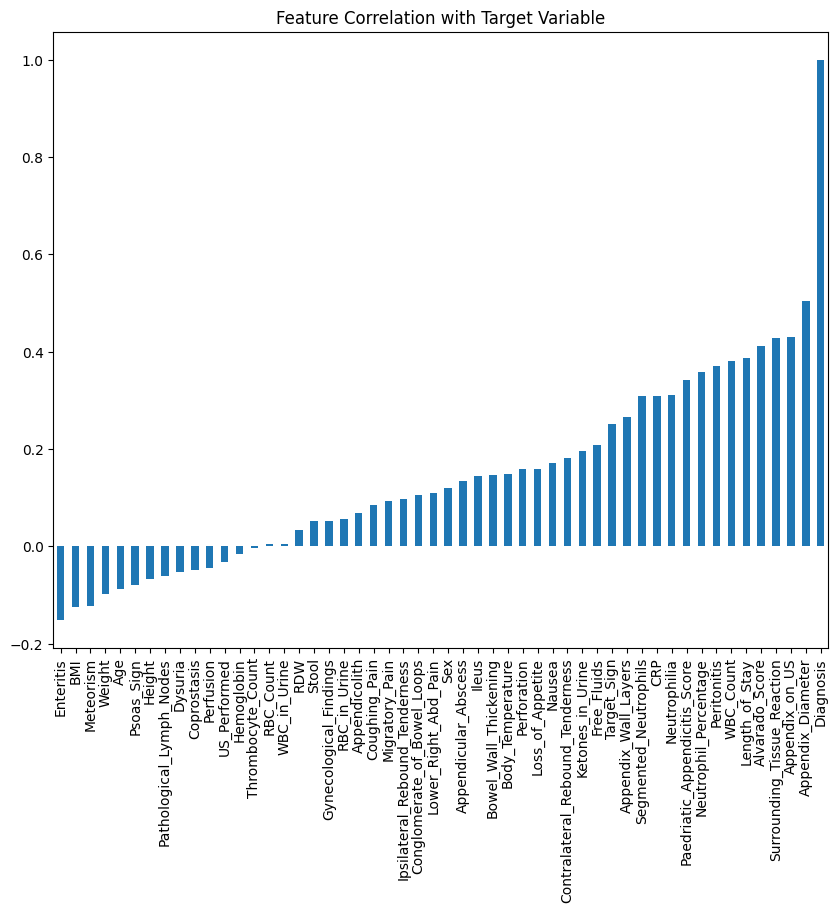

In [19]:
# Calculate the correlation of all features with the target variable
feature_target_corr = data.corrwith(data['Diagnosis'])

# Plot the correlations
plt.figure(figsize=(10, 8))
feature_target_corr.sort_values().plot(kind='bar')
plt.title('Feature Correlation with Target Variable')
plt.show()

Through this exploratory data analysis, we've comprehensively examined our dataset from multiple angles, starting with outlier detection to ensure the robustness of our findings. By analyzing feature correlations and applying PCA, we've gained insights into the underlying structure of the data, which helped identify key features and reduce dimensionality. The Random Forest model allowed us to understand feature importance from a predictive modeling perspective, while LASSO and Elastic Net helped refine our feature set further, ensuring that our models are both interpretable and efficient. Lastly, examining how features correlate with the target variable provided a direct link to potential predictive power, guiding our subsequent modeling efforts. This thorough EDA has set a solid foundation for building predictive models that are insightful, accurate, and relevant to our objectives.